In [1]:
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import numpy as np
import pandas as pd
from pyert.pyert_core.analytic_geometric_factor import analytic_geometric_factor as geom_fact
import pygimli as pg
import pygimli.meshtools as mt
from pygimli.physics.ert import createERTData
from pygimli.physics.ert import simulate as simulateERT

In [2]:
show_args = {'cMap':'Spectral_r', 'cMin':5., 'cMax':50., 'showMesh':True, 'colorBar':True,}

In [3]:
background = mt.createPolygon([(0,0),(5,0),(5,-8),(0,-8)], isClosed= True, marker=1)

In [4]:
anomaly = mt.createPolygon([(2.,-5),(2.,-2), (3.,-2.5),(3.,-4.5)], isClosed=True,
                         addNodes=2, interpolate='spline', marker=5)

In [5]:
electrodes = []
for i in np.arange(1., 7., 1.):
    background.createNodeWithCheck([1., -i])
    electrodes.append([1., -i])
    background.createNodeWithCheck([4., -i])
    electrodes.append([4., -i])
electrodes = np.array(electrodes)

## Create the mesh

(<matplotlib.axes._subplots.AxesSubplot at 0x7fbcfc991790>,
 <matplotlib.colorbar.Colorbar at 0x7fbcf86b92d0>)

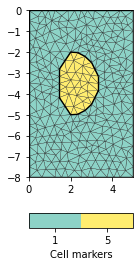

In [6]:
mesh = pg.meshtools.createMesh(background+anomaly, area=.125)
pg.show(mesh,markers=True, showMesh=True)

In [7]:
def material_properties(mesh):
    rho = np.zeros(mesh.cellCount())
    cond = (np.array(mesh.cellCenters())[:,1]>-3.7) & (np.array(mesh.cellMarkers()==1))
    rho[cond] = np.exp(np.random.normal(3.22,.2,len(rho[cond])))
    cond = (np.array(mesh.cellCenters())[:,1]<=-3.7) & (np.array(mesh.cellMarkers()==1))
    rho[cond] = np.exp(np.random.normal(2.08,.2,len(rho[cond])))
    cond = np.array(mesh.cellMarkers()==5)
    rho[cond] = np.exp(np.random.normal(4.08,.3,len(rho[cond])))
    return rho

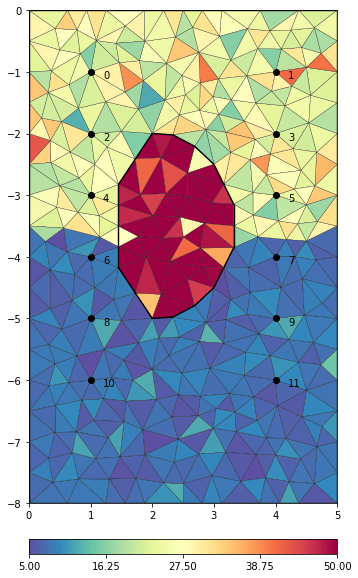

In [8]:
fig, ax = plt.subplots(figsize=(16, 10))
pg.show(mesh, material_properties(mesh), ax=ax, logScale=False, showLater=True, **show_args)
ax.plot(electrodes[:,0], electrodes[:,1], 'ok')
ax.set_ylim([-8, 0])
j=0
for k in electrodes:
    ax.text(k[[0]]+0.2, k[1]-0.1, f'{j}')
    j+=1

## Create the data container

In [9]:
scheme = pg.DataContainerERT()

In [10]:
elecs = electrodes

In [11]:
scheme.setSensors(elecs)

Create the sequence

In [12]:
seq = np.array([[0, 1, 2, 3],[2, 3, 4, 5],[4, 5, 6, 7],
                [6, 7, 8, 9],[8, 9, 10, 11], [0, 1, 4, 5],
                [2, 3, 6, 7],[4, 5, 8, 9],[6, 7, 10, 11]])

In [13]:
s=[]
for i in range(0,len(elecs)-2,2):
    #print('A={} B={} M={} N={}'.format(i,i+2,i+1,i+3))
    s.append([i,i+2,i+1,i+3])

for i in range(1,len(elecs)-1,2):
    #print('A={} B={} M={} N={}'.format(i,i+2,i-1,i+1))
    s.append([i,i+2,i-1,i+1])
seq=np.append(seq,np.array(s), axis=0)

Specificy electrode positions

In [14]:
pos  = {}
for i in range(len(electrodes)):
    pos.update({i : list(electrodes[i])})
pos

{0: [1.0, -1.0],
 1: [4.0, -1.0],
 2: [1.0, -2.0],
 3: [4.0, -2.0],
 4: [1.0, -3.0],
 5: [4.0, -3.0],
 6: [1.0, -4.0],
 7: [4.0, -4.0],
 8: [1.0, -5.0],
 9: [4.0, -5.0],
 10: [1.0, -6.0],
 11: [4.0, -6.0]}

Convert sequence of electrodes to sequence of positions

In [15]:
pos_seq = []
for s in seq:
    l=[]
    for i in [pos[x] for x in s]:
        j= i.copy()
        j.append(0)
        l.append(j)
    pos_seq.append(l)
pos_seq

[[[1.0, -1.0, 0], [4.0, -1.0, 0], [1.0, -2.0, 0], [4.0, -2.0, 0]],
 [[1.0, -2.0, 0], [4.0, -2.0, 0], [1.0, -3.0, 0], [4.0, -3.0, 0]],
 [[1.0, -3.0, 0], [4.0, -3.0, 0], [1.0, -4.0, 0], [4.0, -4.0, 0]],
 [[1.0, -4.0, 0], [4.0, -4.0, 0], [1.0, -5.0, 0], [4.0, -5.0, 0]],
 [[1.0, -5.0, 0], [4.0, -5.0, 0], [1.0, -6.0, 0], [4.0, -6.0, 0]],
 [[1.0, -1.0, 0], [4.0, -1.0, 0], [1.0, -3.0, 0], [4.0, -3.0, 0]],
 [[1.0, -2.0, 0], [4.0, -2.0, 0], [1.0, -4.0, 0], [4.0, -4.0, 0]],
 [[1.0, -3.0, 0], [4.0, -3.0, 0], [1.0, -5.0, 0], [4.0, -5.0, 0]],
 [[1.0, -4.0, 0], [4.0, -4.0, 0], [1.0, -6.0, 0], [4.0, -6.0, 0]],
 [[1.0, -1.0, 0], [1.0, -2.0, 0], [4.0, -1.0, 0], [4.0, -2.0, 0]],
 [[1.0, -2.0, 0], [1.0, -3.0, 0], [4.0, -2.0, 0], [4.0, -3.0, 0]],
 [[1.0, -3.0, 0], [1.0, -4.0, 0], [4.0, -3.0, 0], [4.0, -4.0, 0]],
 [[1.0, -4.0, 0], [1.0, -5.0, 0], [4.0, -4.0, 0], [4.0, -5.0, 0]],
 [[1.0, -5.0, 0], [1.0, -6.0, 0], [4.0, -5.0, 0], [4.0, -6.0, 0]],
 [[4.0, -1.0, 0], [4.0, -2.0, 0], [1.0, -1.0, 0], [1.0, -2.0, 

Compute the geometric factors 

In [16]:
k = [geom_fact(np.array(l), np.array([0., 1., 0., 0.])) for l in pos_seq]

Insert sequence into the data container

In [17]:
scheme.resize(len(seq))

In [18]:
scheme.add('a', seq[:,0])
scheme.add('b', seq[:,1])
scheme.add('m', seq[:,2])
scheme.add('n', seq[:,3])
scheme.add('k', k)
scheme.set('valid', np.ones(len(seq)))

Create and display forward mesh

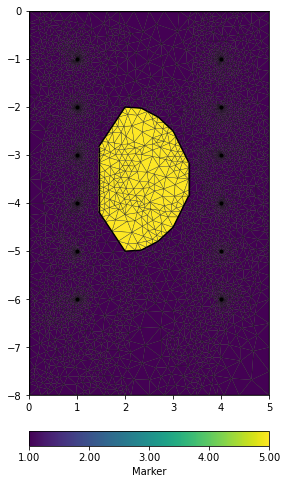

In [19]:
for s in scheme.sensors():
    mesh.createNode(s + [0.0, -0.02])

# Now we can create our forward modeling mesh.
fw_mesh = mt.createMesh(mesh, quality=31)

fig, ax = plt.subplots(figsize=(16, 8))
pg.show(fw_mesh, ax=ax, data=fw_mesh.cellMarkers(), label='Marker', showMesh=True)
ax.plot([v[0] for _,v in pos.items()], [v[1] for _,v in pos.items()], '.k')

Populate the mesh with resistivites drawn from two distrbutions

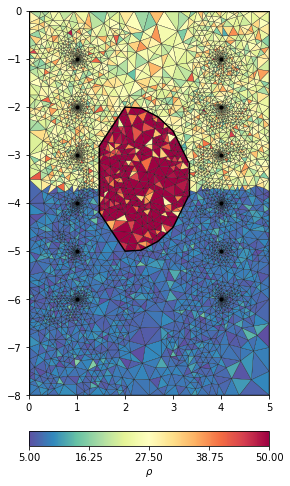

In [20]:
fig, ax = plt.subplots(figsize=(16, 8))
pg.show(fw_mesh, ax=ax, data=material_properties(fw_mesh), label=r'$\rho$', **show_args)
ax.plot([v[0] for _,v in pos.items()], [v[1] for _,v in pos.items()], '.k')

Simulate apparent resistivities

In [21]:
data = simulateERT(fw_mesh, res=material_properties(fw_mesh), scheme=scheme, verbose=True, noiseLevel=0.001, noiseAbs=1.e-6)

Data error estimate (min:max)  0.0010002483397751763 : 0.001036500640919739


In [22]:
def DataContainerERT_to_df(data_container):
    cols = np.array(data_container.dataMap())[:,0]
    data = np.vstack([data_container.get(i) for i in cols]).T
    df = pd.DataFrame(data=data, columns=cols)
    return df

In [23]:
df = DataContainerERT_to_df(data)

In [24]:
df

,a,b,err,i,ip,iperr,k,m,n,r,rhoa,u,valid
0,0.0,1.0,0.001000,0.0,0.0,0.0,8.040899,2.0,3.0,0.0,32.388094,0.0,1.0
1,2.0,3.0,0.001000,0.0,0.0,0.0,8.821308,4.0,5.0,0.0,30.468256,0.0,1.0
2,4.0,5.0,0.001000,0.0,0.0,0.0,9.036355,6.0,7.0,0.0,20.101040,0.0,1.0
3,6.0,7.0,0.001001,0.0,0.0,0.0,9.113011,8.0,9.0,0.0,16.599691,0.0,1.0
4,8.0,9.0,0.001001,0.0,0.0,0.0,9.146156,10.0,11.0,0.0,12.198864,0.0,1.0
5,0.0,1.0,0.001001,0.0,0.0,0.0,23.044884,4.0,5.0,0.0,34.388349,0.0,1.0
6,2.0,3.0,0.001001,0.0,0.0,0.0,26.153200,6.0,7.0,0.0,24.006151,0.0,1.0
7,4.0,5.0,0.001001,0.0,0.0,0.0,27.246083,8.0,9.0,0.0,24.684400,0.0,1.0
8,6.0,7.0,0.001001,0.0,0.0,0.0,27.695424,10.0,11.0,0.0,21.182197,0.0,1.0
9,0.0,2.0,0.001010,0.0,0.0,0.0,312.933256,1.0,3.0,0.0,31.894368,0.0,1.0


Insert an error on the simulated apparent resistivites

In [25]:
df['err'] = 0.001 * df['rhoa']

In [26]:
df

,a,b,err,i,ip,iperr,k,m,n,r,rhoa,u,valid
0,0.0,1.0,0.032388,0.0,0.0,0.0,8.040899,2.0,3.0,0.0,32.388094,0.0,1.0
1,2.0,3.0,0.030468,0.0,0.0,0.0,8.821308,4.0,5.0,0.0,30.468256,0.0,1.0
2,4.0,5.0,0.020101,0.0,0.0,0.0,9.036355,6.0,7.0,0.0,20.101040,0.0,1.0
3,6.0,7.0,0.016600,0.0,0.0,0.0,9.113011,8.0,9.0,0.0,16.599691,0.0,1.0
4,8.0,9.0,0.012199,0.0,0.0,0.0,9.146156,10.0,11.0,0.0,12.198864,0.0,1.0
5,0.0,1.0,0.034388,0.0,0.0,0.0,23.044884,4.0,5.0,0.0,34.388349,0.0,1.0
6,2.0,3.0,0.024006,0.0,0.0,0.0,26.153200,6.0,7.0,0.0,24.006151,0.0,1.0
7,4.0,5.0,0.024684,0.0,0.0,0.0,27.246083,8.0,9.0,0.0,24.684400,0.0,1.0
8,6.0,7.0,0.021182,0.0,0.0,0.0,27.695424,10.0,11.0,0.0,21.182197,0.0,1.0
9,0.0,2.0,0.031894,0.0,0.0,0.0,312.933256,1.0,3.0,0.0,31.894368,0.0,1.0


Update the data container

In [27]:
data.set('err', pg.core.asvector(df['err']))

do not use asvector(ndarray) use ndarray directly .. this method will be removed soon


## Invert the simulated dataset

In [28]:
ert = pg.physics.ERTManager(sr=False, useBert=True, verbose=True, debug=False)

Create on inversion mesh

In [29]:
from pygimli.meshtools import appendTriangleBoundary, merge2Meshes

In [30]:
for cell in mesh.cells():
    cell.setMarker(1)

(<matplotlib.axes._subplots.AxesSubplot at 0x7fbcf85c2590>,
 <matplotlib.colorbar.Colorbar at 0x7fbcf84ce7d0>)

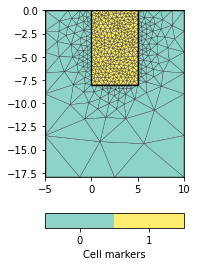

In [31]:
inv_mesh = appendTriangleBoundary(mesh, -10., 10., quality=31, smooth=True,
                              marker=0, isSubSurface=True)

pg.show(inv_mesh, markers=True, showMesh=True)

model = []
phi = []
for lam in np.arange(.1, 3.1, .1):
    model.append(ert.invert(data=data, mesh=inv_mesh, lam=lam))
    phi.append([ert.inv.phiData(), ert.inv.phiModel()])

phi = np.array(phi)

fig, ax = plt.subplots(figsize=(12,12))
ax.plot(phi[:,0], phi[:,1], '-k')
ax.plot(phi[:,0], phi[:,1], 'ok')
lams = np.arange(.1, 3.1, .1)
for i in range(len(lams)):
    ax.text(phi[i,0]+0.2, phi[i,1], f'{lams[i]:.1f}')
ax.set_xlabel('data misfit')
ax.set_ylabel('model misfit')

In [32]:
model = ert.invert(data=data, mesh=inv_mesh,lam=.8)#0.85
chi2 = ert.inv.chi2()
print(f'Khi-2: {chi2}')

17/11/20 - 11:55:06 - pyGIMLi - INFO - Found 2 regions.
17/11/20 - 11:55:06 - pyGIMLi - INFO - Region with smallest marker (0) set to background
17/11/20 - 11:55:06 - pyGIMLi - INFO - Creating forward mesh from region infos.
17/11/20 - 11:55:06 - Core - WARNING - Region Nr: 0  is background and should not get a model transformation.
17/11/20 - 11:55:06 - Core - WARNING - Region Nr: 0  is background and should not get a model control.
17/11/20 - 11:55:06 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
17/11/20 - 11:55:06 - pyGIMLi - INFO - Starting inversion.
17/11/20 - 11:55:06 - pyGIMLi - INFO - Set default startmodel to median(data values)=24.68440034904654
17/11/20 - 11:55:06 - pyGIMLi - INFO - Created startmodel from forward operator: 526 [24.68440034904654,...,24.68440034904654]


fop: <pygimli.physics.ert.ert.ERTModelling object at 0x7fbcf8681570>
Data transformation: <pygimli.core._pygimli_.RTransLogLU object at 0x7fbcf86817f0>
Model transformation: <pygimli.core._pygimli_.RTransLog object at 0x7fbcf8681330>
min/max (data): 9.72/47.66
min/max (error): 0.97%/4.77%
min/max (start model): 24.68/24.68
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... chi² = 11.33 (dPhi = 42.59%) lam: 0.8
--------------------------------------------------------------------------------
inv.iter 3 ... chi² = 9.36 (dPhi = 16.14%) lam: 0.8
--------------------------------------------------------------------------------
inv.iter 4 ... chi² = 8.55 (dPhi = 7.87%) lam: 0.8
--------------------------------------------------------------------------------
inv.iter 5 ... chi² = 8.11 (dPhi = 4.59%) lam: 0.8
---------------------------------------------------------------

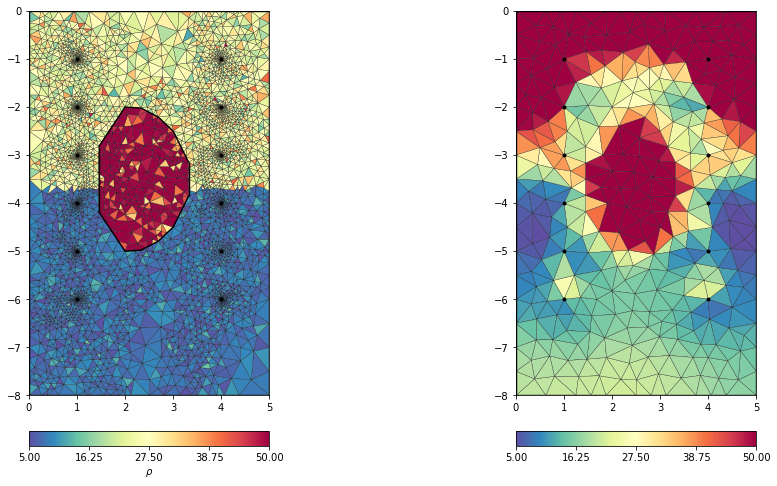

In [37]:
fig, _ = plt.subplots(figsize=(16, 8))
ax1 = plt.subplot(121)
pg.show(fw_mesh, ax=ax1, data=material_properties(fw_mesh), label=r'$\rho$', **show_args)
ax1.plot([v[0] for _,v in pos.items()], [v[1] for _,v in pos.items()], '.k')
ax2 = plt.subplot(122)
pg.show(ert.paraDomain, data = ert.paraModel(), ax=ax2, **show_args)
ax2.plot([v[0] for _,v in pos.items()], [v[1] for _,v in pos.items()], '.k')